# Étude du lien entre les notes attribuées et la présence d'équipements

## I- Import des données

In [1]:
!pip install openpyxl
import pandas as pd
import requests
import io
import zipfile
import sklearn
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 3.7 MB/s eta 0:00:00a 0:00:01


In [2]:
# Reading the Zipfile with information about equipments in 2021
url = 'https://www.insee.fr/fr/statistiques/fichier/3568638/bpe21_ensemble_xy_csv.zip'
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

# We obtain two csv files

In [3]:
# Reading the file with information about equipments
dicType = {'BV2012': str, 'DCIRIS': str, 'DEP': str, 'DEPCOM': str, 'DOM': str, 'EPCI': str, 'SDOM': str}
BPE = pd.read_csv('bpe21_ensemble_xy.csv', sep=";", dtype = dicType)

In [15]:
# Reducing the file to keep only Paris
with open('data/bpeParis.csv','w') as f:
    f = BPE.loc[BPE['DEP'] == '75']
    f.to_csv(path_or_buf = 'data/bpeParis.csv', index = False)

In [5]:
# We need to delete csv files that are too big to push
# i.e. bpe21_ensemble_xy.csv and Varmod_bpe21_ensemble_xy.csv
os.remove('bpe21_ensemble_xy.csv')
os.remove('Varmod_bpe21_ensemble_xy.csv')

## II- Traitement préliminaire pour associer les IRIS et les arrondissements

La base des équipements utilise le découpage territorial en IRIS, alors que les notes concernent les arrondissements. Pour obtenir des résultats sur les arrondissements, il convient donc d'associer chaque arrondissement aux IRIS qui le composent.

In [6]:
# Getting the file containing matchings between arrondissements and IRIS
url_1 = 'https://www.insee.fr/fr/statistiques/fichier/2017499/reference_IRIS_geo2023.zip'
r1 = requests.get(url_1)
z1 = zipfile.ZipFile(io.BytesIO(r1.content))
z1.extractall(path = 'data/')
Ref_IRIS = pd.read_excel('data/reference_IRIS_geo2023.xlsx')

In [7]:
# Changing the names of the columns
# It is only further in the excel file that we find the right column names
wrong_names = pd.Series.tolist(Ref_IRIS.columns)
col_names = pd.Series.tolist(Ref_IRIS.iloc[4])
dictionary_names = dict(zip(wrong_names, col_names))
Ref_IRIS = Ref_IRIS.rename(columns = dictionary_names)

# We obtain the right names of columns

In [8]:
# Obtaining a list with IRIS in the 1st arrondissement of Paris
Arr1 = Ref_IRIS[Ref_IRIS['LIBCOM'] == 'Paris 1er Arrondissement']
liste1 = pd.Series.tolist(Arr1['CODE_IRIS'])

In [9]:
#The same with all the other arrondissements
dicIRIS = {'Paris 1er Arrondissement': liste1}
for i in range(2,21):
    j = str(i)
    key_arr = 'Paris ' + j + 'e Arrondissement'
    Arr = Ref_IRIS[Ref_IRIS['LIBCOM'] == key_arr]
    val_arr = pd.Series.tolist(Arr['CODE_IRIS'])
    dicIRIS[key_arr] = val_arr

# We obtain a dictionary with the name of the arrondissement as a key 
# and a list with the numbers of IRIS corresponding as a value

## III- Étude des commerces

Nous nous intéressons ici à la catégorie B dans le fichier bpeParis.csv

### A- Préambule

In [11]:
dicType = {'BV2012': str, 'DCIRIS': str, 'DEP': str, 'DEPCOM': str, 'DOM': str, 'EPCI': str, 'SDOM': str}
BPE = pd.read_csv('data/bpeParis.csv', sep=",", dtype = dicType)

In [12]:
# Number of "Grandes surfaces" (B1) by arrondissement

# Concerning the 1st arrondissement of Paris
n1 = 0 # Number initialized
for iris in dicIRIS['Paris 1er Arrondissement']:
    col = BPE[(BPE['DCIRIS'] == iris) & (BPE['SDOM'] == 'B1')]
    n1 += len(col) # number of lines

# Concerning the rest of the arrondissements
dicB1 = {'1er Arrondissement': n1}
n = 0
for i in range(2,21):
    key_arr = 'Paris ' + str(i) + 'e Arrondissement'
    for iris in dicIRIS[key_arr]:
        col = BPE[(BPE['DCIRIS'] == iris) & (BPE['SDOM'] == 'B1')]
        n += len(col)
    dicB1[str(i) + 'e Arrondissement'] = n
    n = 0

# We obtain a dictionary with the name of the arrondissement as a key 
# and the number of "Grandes surfaces" as a value

In [16]:
# Number of "commerces alimentaires" (B2) by arrondissement

# Concerning the 1st arrondissement of Paris
n1 = 0 # Number initialized
for iris in dicIRIS['Paris 1er Arrondissement']:
    col = BPE[(BPE['DCIRIS'] == iris) & (BPE['SDOM'] == 'B2')]
    n1 += len(col) # number of lines

# Concerning the rest of the arrondissements
dicB2 = {'1er Arrondissement': n1}
n = 0
for i in range(2,21):
    key_arr = 'Paris ' + str(i) + 'e Arrondissement'
    for iris in dicIRIS[key_arr]:
        col = BPE[(BPE['DCIRIS'] == iris) & (BPE['SDOM'] == 'B2')]
        n += len(col)
    dicB2[str(i) + 'e Arrondissement'] = n
    n = 0

# We obtain a dictionary with the name of the arrondissement as a key 
# and the number of "commerces alimentaires" as a value

In [17]:
# More precisely, we want to have the number of each type of equipments whose field is B, i.e. "commerces", for each arrondissement
# To obtain this, we will create a csv file

# Concerning the 1st arrondissement of Paris
n1 = 0 # Number initialized
listType = ['B101', 'B102', 'B103', 'B201', 'B202', 'B203', 'B204', 'B205', 'B206', 'B301', 'B302', 'B303', 'B304', 'B305', 'B306', 'B307', 'B308', 'B309', 'B310', 'B311', 'B312', 'B313', 'B314', 'B315', 'B316']
list1 = []
for type in listType:
    for iris in dicIRIS['Paris 1er Arrondissement']:
        col = BPE[(BPE['DCIRIS'] == iris) & (BPE['TYPEQU'] == type)]
        n1 += len(col) # number of lines
    list1.append(n1)
    n1 = 0

# Concerning the rest of the arrondissements
dicB = {'1er Arrondissement': list1}
n = 0
for arr in range(2,21):
    key_arr = 'Paris ' + str(arr) + 'e Arrondissement'
    listBType = []
    for type in listType:
        for iris in dicIRIS[key_arr]:
            col = BPE[(BPE['DCIRIS'] == iris) & (BPE['TYPEQU'] == type)]
            n += len(col)
        listBType.append(n)
        n = 0
    dicB[str(arr) + 'e Arrondissement'] = listBType

Commerces_precis = pd.DataFrame(dicB)
Commerces_precis.set_axis(listType, axis = 0)
Commerces_precis.to_csv(path_or_buf = 'data/Commerces.csv', index = False)

# Each row is one type of equipment

### B- Régressions

In [21]:
# Reading the excel file containing the grades obtained by each arrondissement in varied fields
# We only focus on the category 'Commerces'
Notes_arr = pd.read_excel('Notes_arrondissements.xlsx', decimal = ",")
notes = pd.Series(Notes_arr['Commerces'])
notes = pd.Series.tolist(notes)

Commerces = pd.read_csv('data/Commerces.csv')

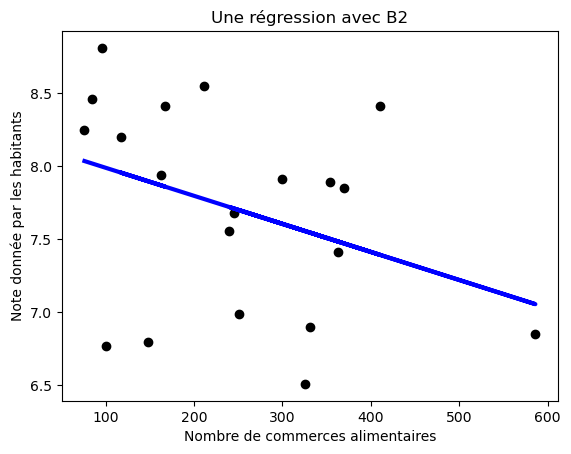

In [22]:
# Trying to make a regression with only B2
listB2 = pd.DataFrame(dicB2.values())
reg = LinearRegression().fit(listB2, notes)
y_pred = reg.predict(listB2)

plt.scatter(listB2, notes, color="black")
plt.plot(listB2, y_pred, color="blue", linewidth=3)
plt.xlabel('Nombre de commerces alimentaires')
plt.ylabel('Note donnée par les habitants')
plt.title('Une régression avec B2')
plt.show()

# Not very satisfactory since y_pred is surprisingly decreasing

In [40]:
# The same but by splitting the dataframe
# Split the data into training/testing sets
X_trainB2, X_testB2, y_trainB2, y_testB2 = sklearn.model_selection.train_test_split(listB2, notes, test_size = 0.5)

In [41]:
# Making a regression using the arrondissements in train
regB2 = LinearRegression().fit(X_trainB2, y_trainB2)

# Make predictions using the testing set
y_predB2 = regB2.predict(X_testB2)

In [42]:
# The coefficients
regB2.coef_

array([-0.00207359])

In [43]:
regB2.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

In [44]:
regB2.score(X_testB2, y_testB2)

0.03884393372656747

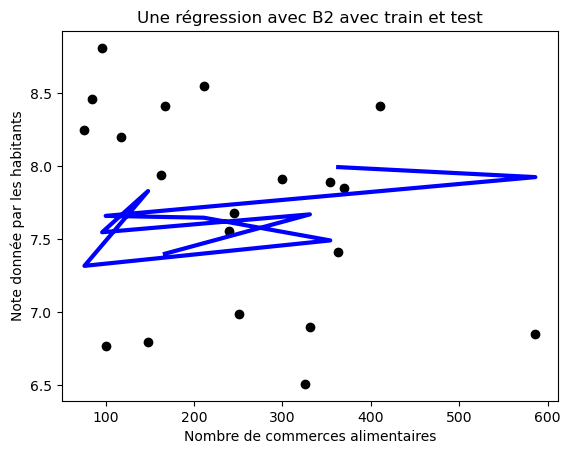

In [46]:
plt.scatter(listB2, notes, color="black")
plt.plot(X_trainB2, y_predB2, color="blue", linewidth=3)
plt.xlabel('Nombre de commerces alimentaires')
plt.ylabel('Note donnée par les habitants')
plt.title('Une régression avec B2 avec train et test')
plt.show()

On utilise les informations plus précises sur les différents types de commerces.

In [30]:
# Split the data into training/testing sets
Commerces2 = Commerces.transpose()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(Commerces2, notes, test_size = 0.5)

In [35]:
# Making a regression using the arrondissements in train
reg = LinearRegression().fit(X_train, y_train)

# Make predictions using the testing set
y_pred = reg.predict(X_test)

In [36]:
# The coefficients
reg.coef_

array([ 0.00231229, -0.007791  ,  0.00454562, -0.00910527,  0.00742093,
        0.00906845, -0.02403478,  0.00412365, -0.01019482,  0.00996082,
        0.00247953, -0.02763859,  0.00025882,  0.02642039, -0.01765573,
        0.01534368,  0.00334558,  0.00392962, -0.02731844,  0.02681186,
       -0.01406701,  0.0112068 ,  0.        , -0.00030321, -0.00207437])

In [37]:
reg.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

In [38]:
# The R^2
reg.score(X_test, y_test)

-0.569779652937501

## IV- Étude de l'enseignement

Nous nous intéressons ici à la catégorie C dans le fichier bpeParis.csv

## V- Étude de la santé

Nous nous intéressons ici à la catégorie D dans le fichier bpeParis.csv

## VI- Étude des transports

Nous nous intéressons ici à la catégorie E dans le fichier bpeParis.csv